# Import important packages


In [6]:
import argparse
from pathlib import Path

import numpy as np
import math
import json
from tqdm.notebook import tqdm as tqdm
import logging
import os
import shutil
import sys
import time
from collections import defaultdict
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset


# Pip pytorch-lightning package
import pytorch_lightning as pl
from pytorch_lightning.strategies import DDPSpawnStrategy
from pytorch_lightning.core.module import LightningModule
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.plugins import DDPPlugin, DDPShardedPlugin
from torch.nn.functional import softmax
from torch.utils.data import DataLoader

# Pip Huggingface Transformers package
import transformers
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import (
    AutoModelForMultipleChoice,
    AutoModelForNextSentencePrediction,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)
from transformers import BertTokenizerFast

# Pip Huggingface Datasets package
import datasets

NameError: name '_C' is not defined

# **Phase 0: Get datasets and preprocessing, cleaning**
Our dataset is Agnews, AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity


The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015)

## Mount google drive (to save checkpoints, models)

In [13]:
# Mount google drive (to save checkpoints, models)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download Datasets from HuggingFace

In [ ]:
# Get datasets from huggingface
agnews = datasets.load_dataset("ag_news", cache_dir="./datasets")
# g20news = datasets.load_dataset("SetFit/20_newsgroups")
# yelp_reviews = datasets.load_dataset("yelp_review_full")
# dbpedia = datasets.load_dataset("dbpedia_14")

  0%|          | 0/2 [00:00<?, ?it/s]

## Prepare dataset into suitable form for the model

In [15]:
# Pre-process dataset
import json
train_data = agnews['train']
test_data = agnews['test']

# Create training data
texts = train_data['text']
labels = train_data['label']

classes = train_data.unique('label')
classes.sort()
classes = [str(c) for c in classes]
data = [{'text': text, 'label': label} for text, label in zip(texts, labels)]

out_data = {"classes": classes, "data": data}
with open('agnews_train.json', "w", encoding="utf-8") as wf:
    json.dump(out_data, wf, indent=4, ensure_ascii=False)


# Create test data
texts = train_data['text']
labels = train_data['label']

classes = train_data.unique('label')
classes.sort()
classes = [str(c) for c in classes]
data = [{'text': text, 'label': label} for text, label in zip(texts, labels)]

out_data = {"classes": classes, "data": data}
with open('agnews_test.json', "w", encoding="utf-8") as wf:
    json.dump(out_data, wf, indent=4, ensure_ascii=False)

### Dataset demo

In [16]:
# Check out dataset (in case in need of cleaning n/a stuffs)
with open('/content/agnews_train.json', "r", encoding="utf-8") as rf:
    data = json.load(rf)
    print(data['classes'])
    for i in range(10):
        print(data['data'][i])

['0', '1', '2', '3']
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
{'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'label': 2}
{'text': "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'label': 2}
{'text': 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official sai

# **Phase 1: Create pseudo labels**

## Check machine's GPU

In [ ]:
!nvidia-smi

Fri Dec 30 13:33:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create different verbalizer/prompt generator for each type of dataset

In [ ]:
def topic_verbalizer(category):
    hypothesis = f"This text is about {category.lower()}."
    return hypothesis


def location_verbalizer(category):
    hypothesis = f"This happened in {category.lower().capitalize()}."
    return hypothesis


def review_verbalizer(category):
    if category == "good":
        return "I recommend this place."
    elif category == "bad":
        return "I don't recommend this place."
    else:
        raise ValueError("Invalid category:", category)


def clickbait_verbalizer(category, model=None):
    if category == "news":
        return "This is news."
    elif category == "gossip":
        return "This is gossip."
    else:
        raise ValueError("Invalid category:", category)


def emotion_verbalizer(category, model=None):
    if category == "angry":
        return "I'm angry."
    elif category == "happy":
        return "I'm happy."
    elif category == "optimistic":
        if model == "qa":
            return "Looks good."
        else:
            return "I'm fine."
    elif category == "sad":
        return "I'm sad."
    else:
        raise ValueError("Invalid category:", category)


def classify_nsp(model, tokenizer, categories, verbalizer, text):
    hypotheses = [(text, verbalizer(category)) for category in categories]
    tokenized = tokenizer(
        hypotheses,
        truncation="only_first",
        padding="longest",
        return_tensors="pt",
        add_special_tokens=True,
    )
    logits = model(**tokenized.to(model.device))[0]
    nsp_probs = logits[:, 0]
    probs = nsp_probs.softmax(dim=0)
    max_index = torch.argmax(probs)
    category = categories[max_index]
    return max_index, probs.tolist()


def classify_reverse_nsp(model, tokenizer, categories, verbalizer, text):
    hypotheses = [(verbalizer(category, "rnsp"), text) for category in categories]
    tokenized = tokenizer(
        hypotheses,
        truncation="only_second",
        padding="longest",
        return_tensors="pt",
        add_special_tokens=True,
    )
    logits = model(**tokenized.to(model.device))[0]
    nsp_probs = logits[:, 0]
    probs = nsp_probs.softmax(dim=0)
    max_index = torch.argmax(probs)
    category = categories[max_index]
    return max_index, probs.tolist()


def classify_entailment(model, tokenizer, categories, verbalizer, text):
    hypotheses = [(text, verbalizer(category)) for category in categories]
    tokenized = tokenizer(
        hypotheses,
        truncation="only_first",
        padding="longest",
        return_tensors="pt",
    )
    logits = model(**tokenized.to(model.device))[0]
    logits_label_is_true = logits[:, 2]
    max_index = torch.argmax(logits_label_is_true)
    category = categories[max_index]
    probs = torch.softmax(logits_label_is_true, dim=0)
    return max_index, probs.tolist()


def classify_qa(model, tokenizer, categories, verbalizer, text):
    hypotheses = [
        (text, verbalizer(category, "qa"))
        for category in categories
    ]
    tokenized = tokenizer(
        hypotheses,
        truncation="only_first",
        padding="longest",
        return_tensors="pt",
        add_special_tokens=True,
        return_attention_mask=True,
    )
    input_ids = tokenized.input_ids.unsqueeze(0).to(model.device)
    masks = tokenized.attention_mask.unsqueeze(0).to(model.device)
    logits = model(
        input_ids=input_ids,
        attention_mask=masks,
    )[0]
    logits = logits.squeeze(0)
    max_index = torch.argmax(logits)
    probs = torch.softmax(logits, dim=0)
    return max_index, probs.tolist()

if __name__ == "__main__":
    torch.cuda.empty_cache()

    # Example:
    #
    # python scripts/emnlp22/create_pseudo_labels.py \
    #     -d data/20News/data.json \
    #     -o data/20News/preds_nsp.json \
    #     -v topic \
    #     -m nsp

    #=====================================================================================
    # Important parameters
    data_file = 'agnews_train.json'
    out_file = '/content/drive/MyDrive/Resource/Data/pseudo_agnews.json'
    verbalizer = 'topic'
    model_type = 'entailment'
    
    batch_size = 32
    random_seed = 42
    cuda_device = 0
    #======================================================================================
    
    if model_type == "entailment":
        model = AutoModelForSequenceClassification.from_pretrained(
            "facebook/bart-large-mnli"
        )
        tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
        classify = classify_entailment
    elif model_type == "nsp":
        model = AutoModelForNextSentencePrediction.from_pretrained("bert-large-cased")
        tokenizer = AutoTokenizer.from_pretrained("bert-large-cased")
        classify = classify_nsp
    elif model_type == "rnsp":
        model = AutoModelForNextSentencePrediction.from_pretrained("bert-large-cased")
        tokenizer = AutoTokenizer.from_pretrained("bert-large-cased")
        classify = classify_reverse_nsp
    elif model_type == "qa":
        tokenizer = AutoTokenizer.from_pretrained(
            "LIAMF-USP/roberta-large-finetuned-race"
        )
        model = AutoModelForMultipleChoice.from_pretrained(
            "LIAMF-USP/roberta-large-finetuned-race"
            # "ehdwns1516/bert-base-uncased_SWAG"
        )
        classify = classify_qa
    else:
        raise ValueError("Wrong model type.")

    model.to(f"cuda:{cuda_device}")

    if verbalizer == "topic":
        verbalizer = topic_verbalizer
    elif verbalizer == "location":
        verbalizer = location_verbalizer
    elif verbalizer == "review":
        verbalizer = review_verbalizer
    elif verbalizer == "clickbait":
        verbalizer = clickbait_verbalizer
    elif verbalizer == "emotion":
        verbalizer = emotion_verbalizer
    else:
        raise ValueError("Wrong verbalizer.")

    with open(data_file) as rf:
        data = json.load(rf)

    classes = data["classes"]

    print(f"Classes ({len(classes)}): {classes}")
    with torch.no_grad():
        correct = total = 0
        samples = []
        for i, sample in enumerate(tqdm(data["data"])):
            text = sample["text"]
            prediction, probs = classify(model, tokenizer, classes, verbalizer, text)
            # predicted_class = classes[prediction]
            if prediction.item() == sample["label"]:
                correct += 1
            total += 1
            prob = probs[prediction]
            out_sample = {
                "label": sample["label"],
                "prediction": prediction.item(),
                "confidence": probs,
                "text": sample["text"],
            }
            samples.append(out_sample)
        print(f"Stats for {model_type}, {out_file}: {correct / total}")

        out_data = {"classes": classes, "data": samples}
        with open(out_file, "w", encoding = 'utf-8') as wf:
            json.dump(out_data, wf, indent=4, ensure_ascii=False)


Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Classes (4): ['0', '1', '2', '3']


  0%|          | 0/120000 [00:00<?, ?it/s]

Stats for entailment, /content/drive/MyDrive/Resource/Data/pseudo_agnews.json: 0.2306


In [7]:
with open('/content/drive/MyDrive/Resource/Data/pseudo_agnews.json', 'r') as rf:
    data = json.load(rf)
print(len(data['data']))
for i in range(10):
    print(data['data'][i])

120000
{'label': 2, 'prediction': 0, 'confidence': [0.3418368697166443, 0.2763579487800598, 0.20533230900764465, 0.17647284269332886], 'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}
{'label': 2, 'prediction': 1, 'confidence': [0.24538609385490417, 0.31491053104400635, 0.23829953372478485, 0.2014038860797882], 'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'}
{'label': 2, 'prediction': 1, 'confidence': [0.2729177474975586, 0.3149075508117676, 0.22148124873638153, 0.19069349765777588], 'text': "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang

# **Phase 2: Train BERT-based model**

## Pseudo-labels Dataloader to help load data into model fitting

In [29]:
class PseudoDataset(Dataset):
    def __init__(self, data, tokenizer, use_pseudo=True, shuffle=True):

        self.data = data
        self.tokenizer = tokenizer
        self.use_pseudo = use_pseudo
        self.shuffle = shuffle

    def __len__(self):
        return len(self.data["data"])

    def __getitem__(self, index):

        sample = self.data["data"][index]

        label_key = "prediction" if self.use_pseudo else "label"
        label = sample[label_key]
        text = sample["text"]

        input = self.tokenizer(
            text.lower(),
            add_special_tokens=True,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids = input.input_ids.squeeze(0)
        input_mask = input.attention_mask.squeeze(0)
        confidence = torch.tensor(sample["confidence"]) if "confidence" in sample else 0

        return label, confidence, input_ids, input_mask

## Model Architecture
Our main model is a pretrained BERT for Sequence Classification. So the work is fit it with pseudo-labels dataset to see how entailment works with classification task

In [24]:
class BertCategorizerModel(LightningModule):
    def __init__(
        self,
        num_classes,
        use_soft_labels=False,
        language="en",
        class_weights=None,
        warmup_steps=0,
        training_steps=0,
        learning_rate=1e-4,
    ):
        super().__init__()
        self.use_soft_labels = use_soft_labels
        self.language = language
        self.num_classes = num_classes
        self.class_weights = class_weights
        self.warmup_steps = warmup_steps
        self.training_steps = training_steps
        self.learning_rate = learning_rate
        model_name = "kobart" if language == "kr" else "bert-base-uncased"
        self.model = BertForSequenceClassification.from_pretrained(
            model_name, num_labels=num_classes
        )

        self.pad_token_id = self.model.config.pad_token_id
        self.ce_loss = nn.CrossEntropyLoss()
        for param in self.model.bert.embeddings.parameters():
            param.requires_grad = False

    def forward(self, input_ids, input_mask):
        x = self.model(input_ids=input_ids, attention_mask=input_mask)
        return x

    def run_batch(self, batch, batch_idx, predicting=False):
        label, confidence, input_ids, input_mask = batch
        target = confidence if self.use_soft_labels else label

        out = self(input_ids, input_mask).logits
        if not predicting:
            loss = self.ce_loss(out.view(-1, self.num_classes), target)
        else:
            loss = None
        return loss, out

    def training_step(self, batch, batch_idx):
        loss, _ = self.run_batch(batch, batch_idx)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, _ = self.run_batch(batch, batch_idx)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss, out = self.run_batch(batch, batch_idx)
        self.log("test_loss", loss)
        return loss, indices, preds

    def predict_step(self, batch, batch_idx):
        _, out = self.run_batch(batch, batch_idx, predicting=True)
        indices = batch[0]
        preds = out.argmax(dim=-1)
        return indices, preds

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer


## Train model


In [ ]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

In [22]:
def load_model(kwargs, weights=None):

    model_name = "kobert" if kwargs["language"] == "kr" else "bert-base-uncased"
    tokenizer = BertTokenizerFast.from_pretrained(model_name)

    if weights is not None:
        model = BertCategorizerModel.load_from_checkpoint(weights, **kwargs, strict=False)
    else:
        model = BertCategorizerModel(**kwargs)
    return model, tokenizer


def get_class_weights(data):
    count = {class_name: 0 for class_name in data["classes"]}
    for sample in data["data"]:
        count[data["classes"][sample["prediction"]]] += 1
    class_counts = torch.tensor([count[class_name] for class_name in data["classes"]])
    class_weights = 1 / class_counts * class_counts.sum()
    class_weights = torch.clamp(torch.tensor(class_weights), 1, 5)
    return class_weights


def train(
    data,
    supervised,
    use_soft_labels,
    confidence_threshold,
    quick,
    batch_size,
    max_epochs,
    learning_rate,
    warmup_ratio,
    weights,
    name,
    language,
    seed,
):
    seed_everything(seed)

    # Initialize trainer.
    grad_batches = 1
    strategy = None if quick else DDPSpawnStrategy(find_unused_parameters=False)

    checkpoint_callback = ModelCheckpoint(
        monitor="epoch",
        mode="max",
        save_weights_only=True,
        save_top_k=-1,
    )

    lr_monitor = LearningRateMonitor(logging_interval="step")

    # callbacks = [early_stop_callback, checkpoint_callback, lr_monitor]
    callbacks = [checkpoint_callback, lr_monitor]

    version = f"{name}"
    logger = TensorBoardLogger(
        save_dir=os.getcwd(),
        version=version,
        name="lightning_logs",
    )

    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        strategy=strategy,
        callbacks=callbacks,
        # plugins=plugins,
        log_every_n_steps=grad_batches,
        logger=logger,
        accumulate_grad_batches=grad_batches,
        deterministic=True,
        max_epochs=max_epochs,
        # precision=16,
    )

    # Calculate class imbalance:
    num_classes = len(data["classes"])
    if supervised:
        filtered = data["data"]
    else:
        # class_to_index = {class_name: i for i, class_name in enumerate(data["classes"])}
        filtered = [
            sample
            for sample in data["data"]
            if sample["confidence"][sample["prediction"]] >= confidence_threshold
        ]
    data["data"] = filtered
    # class_weights = get_class_weights(data)
    class_weights = None    

    training_steps = len(data["data"]) // grad_batches // trainer.num_devices * max_epochs
    # warmup_steps = int(training_steps * 0.01)
    warmup_steps = int(training_steps * warmup_ratio)
    print("============================================")
    print(f"Training {name}")
    print("===============Dataset Stats================")
    print("Number of classes:", num_classes)
    print("Class weights:", class_weights)
    print("==============Training Stats================")
    print("Train dataloader size:", len(data["data"]))
    print("Supervised training:", supervised)
    print("Soft labels:", use_soft_labels)
    print("Learning rate:", learning_rate)
    print("Warmup ratio:", warmup_ratio)
    print("Max epochs:", max_epochs)
    print("Training steps:", training_steps)
    print("Warmup steps:", warmup_steps)
    print("============================================")
    # class_weights = None

    model_kwargs = {
        "num_classes": num_classes,
        "use_soft_labels": use_soft_labels,
        "language": language,
        "class_weights": class_weights,
        "learning_rate": learning_rate,
        "warmup_steps": warmup_steps,
        "training_steps": training_steps,
    }
    model, tokenizer = load_model(model_kwargs, weights)

    cpu_count = os.cpu_count()
    train_set = PseudoDataset(data, tokenizer, use_pseudo=not supervised)
    train_dataloader = DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=4,
    )

    # Run training.
    print(f"Training {version}")

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
    )

    best_model_path = checkpoint_callback.best_model_path
    if trainer.is_global_zero:
        print(f"Best model checkpoint: {best_model_path}")
        shutil.move(best_model_path, f"/content/drive/MyDrive/Resource/Model saves/{version}.bin")
        print(f"Best model saved as", f"/content/drive/MyDrive/Resource/Model saves/{version}.bin")
        print("SAVED, PID", os.getpid())

        return best_model_path
    else:
        # print("Exiting", os.getpid())
        sys.exit(0)
    time.sleep(3)
    # model = Model.load_from_checkpoint(
    # best_model_path, num_classes=num_classes, language=language
    # )

    return best_model_path

In [ ]:
if __name__ == "__main__":

    do_train = True

    data_file = '/content/pseudo_agnews.json'
    supervised = False
    soft_labels = True
    confidence_threshold = 0.5
    quick = True
    batch_size = 16
    max_epochs = 5
    learning_rate = 1e-4
    warmup_ratio = 0.05
    seed = 42
    name = 'agnews_entailment_0_5_soft_1'

    weights = None
    language = 'en'
    

    with open(data_file, encoding='utf-8') as rf:
        data = json.load(rf)

    best_model_path = train(
        data,
        supervised,
        soft_labels,
        confidence_threshold,
        quick,
        batch_size,
        max_epochs,
        learning_rate,
        warmup_ratio,
        weights, 
        name,
        language,
        seed,
    )

INFO:lightning_lite.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training agnews_entailment_0_5_soft_1
===============Dataset Stats================
Number of classes: 4
Class weights: None
==============Training Stats================
Train dataloader size: 3931
Supervised training: False
Soft labels: True
Learning rate: 0.0001
Warmup ratio: 0.05
Max epochs: 5
Training steps: 19655
Warmup steps: 982


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training agnews_entailment_0_5_soft_1


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                          | Params
----------------------------------------------------------
0 | model   | BertForSequenceClassification | 109 M 
1 | ce_loss | CrossEntropyLoss              | 0     
----------------------------------------------------------
85.6 M    Trainable params
23.8 M    Non-trainable params
109 M     Total params
437.941   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Best model checkpoint: /content/lightning_logs/agnews_entailment_0_5_soft_1/checkpoints/epoch=4-step=1230-v1.ckpt
Best model saved as /content/drive/MyDrive/Resource/Model saves/agnews_entailment_0_5_soft_1.bin
SAVED, PID 447


# Benchmark trained model. Evaluate with F1 score

In [ ]:
def predict(data, weights, batch_size, language):

    num_classes = len(data["classes"])

    model_kwargs = {"num_classes": num_classes, "language": language}
    model, tokenizer = load_model(model_kwargs, weights)

    # Load dataset.
    cpu_count = os.cpu_count()
    test_set = PseudoDataset(data, tokenizer, use_pseudo=False, shuffle=False)
    test_dataloader = DataLoader(
        test_set, batch_size=batch_size, num_workers=2, shuffle=False
    )

    # Initialize trainer.
    # gpus = 0 if quick else -1
    gpus = 0
    strategy = "dp"

    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        strategy=strategy,
        # plugins=plugins,
        deterministic=True,
        # precision=16,
    )

    # Run predictions.
    out = trainer.predict(model, dataloaders=test_dataloader)

    # indices = torch.cat([i for i, _ in out])
    preds = torch.cat([p for _, p in out]).tolist()
    # preds = [data["classes"][pred] for pred in preds]
    # For DDP. When DP is finally discontinued.
    # if trainer.is_global_zero:
    # world_size = torch.distributed.get_world_size()
    # gathered_indices = [indices.clone() for _ in range(world_size)]
    # gathered_preds = [preds.clone() for _ in range(world_size)]
    # else:
    # gathered_indices = None
    # gathered_preds = None
    # torch.distributed.gather(indices, gather_list=gathered_indices)
    # torch.distributed.gather(preds, gather_list=gathered_preds)
    # if trainer.is_global_zero:
    # print(gathered_indices.shape)
    # print(gathered_preds.shape)

    return preds

def benchmark(data, weights, batch_size, language):

    classes = [c[:9] for c in data["classes"]]
    preds = predict(data, weights, batch_size, language)
    labels = [sample["label"] for sample in data["data"]]

    macro_f1 = f1_score(labels, preds, average="macro")
    micro_f1 = f1_score(labels, preds, average="micro")
    matrix = confusion_matrix(labels, preds)

    experiment_name = Path(weights).stem
    print("🔥🔥🔥🔥🔥🔥🔥🔥Final Stats🔥🔥🔥🔥🔥🔥🔥🔥🔥")
    print(f"[{experiment_name}] Micro f1: {micro_f1}, Macro f1: {macro_f1}")
    print(f"[{experiment_name}] Confusion matrix:")  
    name_string = "".join(f"{name:10s}" for name in classes)
    print(f"{' '*10}{name_string}")
    for name, row in zip(classes, matrix):
        row_string = "".join(f"{str(v):10s}" for v in row)
        print(f"{name:10s}{row_string}")
    print("🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥")
    return macro_f1, micro_f1, confusion_matrix


if __name__ == "__main__":

    # Example:
    #
    # python scripts/emnlp22/benchmark.py \
    #     -w classifier.bin \
    #     -df data/AGNews/data.json \
    #     -bs 1024


    weights = '/content/drive/MyDrive/Resource/Model saves/agnews_entailment_0_5_soft_1.bin'
    data_file = '/content/agnews_test.json'
    batch_size = 64
    language = 'en'
    name = 'agnews_benchmark'
    
    # parser = argparse.ArgumentParser()
    # parser.add_argument("-w", "--weights", help="Model weights")
    # parser.add_argument("-df", "--data-file", help="File with data")
    # # parser.add_argument("-d", "--device", help="GPU id", default=2)
    # parser.add_argument("-bs", "--batch-size", help="Batch size", default=1, type=int)
    # parser.add_argument("-l", "--language", help="en or kr", default="en")
    # parser.add_argument("-n", "--name", help="Name of experiment", default="result")
    # args = parser.parse_args()

    with open(data_file) as rf:
        data = json.load(rf)

    macro_f1, micro_f1, confusion_matrix = benchmark(
        data,
        weights,
        batch_size,
        language,
    )

    with open(f"/content/drive/MyDrive/Resource/DumpDat/{name}.txt", "w") as wf:
        wf.write(f"Macro F1, Micro F1\n{macro_f1},{micro_f1}")


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Predicting: 0it [00:00, ?it/s]

🔥🔥🔥🔥🔥🔥🔥🔥Final Stats🔥🔥🔥🔥🔥🔥🔥🔥🔥
[agnews_entailment_0_5_soft_1] Micro f1: 0.2548, Macro f1: 0.2172932567589811
[agnews_entailment_0_5_soft_1] Confusion matrix:
          0         1         2         3         
0         731       3659      20376     5234      
1         1020      7164      15000     6816      
2         3960      4111      17786     4143      
3         458       3405      21242     4895      
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥


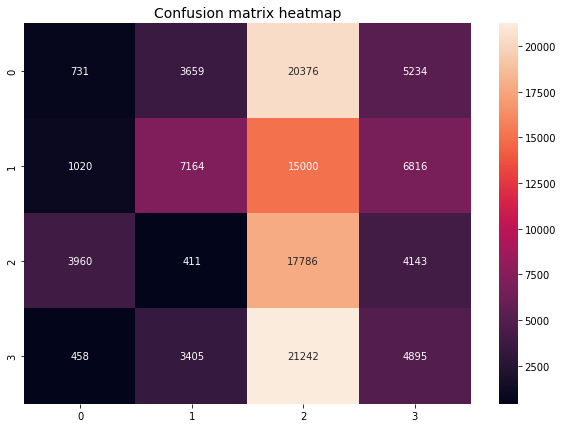

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd


micro_f1 = 0.2548
macro_f1 = 0.2172932567589811
confusion_matrix = [
    [731, 3659, 20376, 5234],
    [1020, 7164, 15000, 6816],
    [3960, 411, 17786, 4143],
    [458, 3405, 21242, 4895]
]

df = pd.DataFrame(confusion_matrix, columns = [i for i in range(0, len(confusion_matrix))])
plt.figure(figsize = (10, 7))
plt.title('Confusion matrix heatmap', fontsize=14)

sn.heatmap(df, annot=True, fmt='g')

# Predict demo

In [30]:
def predict(data, weights, batch_size, language):

    num_classes = len(data["classes"])

    model_kwargs = {"num_classes": num_classes, "language": language}
    model, tokenizer = load_model(model_kwargs, weights)

    # Load dataset.
    cpu_count = os.cpu_count()
    test_set = PseudoDataset(data, tokenizer, use_pseudo=False, shuffle=False)
    test_dataloader = DataLoader(
        test_set, batch_size=batch_size, num_workers=2, shuffle=False
    )

    # Initialize trainer.
    # gpus = 0 if quick else -1
    gpus = 0
    strategy = "dp"

    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        strategy=strategy,
        # plugins=plugins,
        deterministic=True,
        # precision=16,
    )

    # Run predictions.
    out = trainer.predict(model, dataloaders=test_dataloader)

    # indices = torch.cat([i for i, _ in out])
    preds = torch.cat([p for _, p in out]).tolist()
    # preds = [data["classes"][pred] for pred in preds]
    # For DDP. When DP is finally discontinued.
    # if trainer.is_global_zero:
    # world_size = torch.distributed.get_world_size()
    # gathered_indices = [indices.clone() for _ in range(world_size)]
    # gathered_preds = [preds.clone() for _ in range(world_size)]
    # else:
    # gathered_indices = None
    # gathered_preds = None
    # torch.distributed.gather(indices, gather_list=gathered_indices)
    # torch.distributed.gather(preds, gather_list=gathered_preds)
    # if trainer.is_global_zero:
    # print(gathered_indices.shape)
    # print(gathered_preds.shape)

    return preds

weights = '/content/drive/MyDrive/Resource/Model_saves/agnews_entailment_0_5_soft_1.bin'
data_file = '/content/agnews_test.json'
batch_size = 64
language = 'en'
name = 'agnews_benchmark'
    
    # parser = argparse.ArgumentParser()
    # parser.add_argument("-w", "--weights", help="Model weights")
    # parser.add_argument("-df", "--data-file", help="File with data")
    # # parser.add_argument("-d", "--device", help="GPU id", default=2)
    # parser.add_argument("-bs", "--batch-size", help="Batch size", default=1, type=int)
    # parser.add_argument("-l", "--language", help="en or kr", default="en")
    # parser.add_argument("-n", "--name", help="Name of experiment", default="result")
    # args = parser.parse_args()

with open(data_file) as rf:
    data = json.load(rf)
    data['data'] = data['data'][0:10]
print(data)
results = predict(
    data,
        weights,
    batch_size,
    language,
)

{'classes': ['0', '1', '2', '3'], 'data': [{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}, {'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'label': 2}, {'text': "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'label': 2}, {'text': 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastruc

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Predicting: 0it [00:00, ?it/s]

In [33]:
print(results)

[2, 3, 0, 2, 3, 0, 1, 0, 2, 2]


In [51]:
df = pd.DataFrame(data['data'])
df.columns = ['Text', 'True label']
df['Pred label'] = results
df.head(10)

,Text,True label,Pred label
0,Wall St. Bears Claw Back Into the Black (Reute...,2,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,3
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,0
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,2
4,"Oil prices soar to all-time record, posing new...",2,3
5,"Stocks End Up, But Near Year Lows (Reuters) Re...",2,0
6,Money Funds Fell in Latest Week (AP) AP - Asse...,2,1
7,Fed minutes show dissent over inflation (USATO...,2,0
8,Safety Net (Forbes.com) Forbes.com - After ear...,2,2
9,Wall St. Bears Claw Back Into the Black NEW Y...,2,2
